In [17]:
# @title Install madrona_mjx and quadruped_mjx_rl

# install additional missing packages
!sudo apt install -y libx11-dev libxrandr-dev libxinerama-dev libxcursor-dev libxi-dev mesa-common-dev
# the following is for kaggle
#!sudo apt install -y nvidia-cuda-toolkit

# install jax with cuda enabled
!pip install -U "jax[cuda12_local]==0.5.2"

# get madrona mjx and its subpackages
!mkdir modules
!git clone https://github.com/shacklettbp/madrona_mjx.git modules/madrona_mjx
!git -C modules/madrona_mjx submodule update --init --recursive

# build madrona mjx
!mkdir modules/madrona_mjx/build
!cd modules/madrona_mjx/build && cmake -DLOAD_VULKAN=OFF .. && make -j 8

# install madrona mjx
!pip install -e modules/madrona_mjx

# Clones and installs our Quadruped RL package
!git clone https://github.com/alexeiplatzer/unitree-go2-mjx-rl.git
!pip install -e unitree-go2-mjx-rl

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libxcursor-dev is already the newest version (1:1.2.0-2build4).
libxi-dev is already the newest version (2:1.8-1build1).
libxinerama-dev is already the newest version (2:1.1.4-3).
libxrandr-dev is already the newest version (2:1.5.2-1build1).
libx11-dev is already the newest version (2:1.7.5-1ubuntu0.3).
mesa-common-dev is already the newest version (23.2.1-1ubuntu3.1~22.04.3).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.
mkdir: cannot create directory ‘modules’: File exists
fatal: destination path 'modules/madrona_mjx' already exists and is not an empty directory.
mkdir: cannot create directory ‘modules/madrona_mjx/build’: File exists
-- Populating madronabundledtoolchain
-- Configuring done (0.0s)
-- Generating done (0.0s)
-- Build files have been written to: /content/modules/madrona_mjx/external/madrona/external/madrona-toolchain/cmake-tmp/madronabundledtoolchain-subbu

fatal: destination path 'unitree-go2-mjx-rl' already exists and is not an empty directory.
Obtaining file:///content/unitree-go2-mjx-rl
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for quadruped_mjx_rl (pyproject.toml) ... done
  Created wheel for quadruped_mjx_rl: filename=quadruped_mjx_rl-0.0.1-0.editable-py3-none-any.whl size=1945 sha256=80ae03f605a5c5f4243c1e49e0412229fc1584252908f94710a44ae54860e0df
  Stored in directory: /tmp/pip-ephem-wheel-cache-6ivi77g9/wheels/f5/17/dc/1310c3fc1ac418e3ffd03caf359f7d6df62e5e764b13e82f9a
Successfully built quadruped_mjx_rl
  Attempting uninstall: quadruped_mjx_rl
    Found existing installation: quadruped_mjx_rl 0.0.1
    Uninstalling quadruped_mjx_rl-0.0.1:
      Successfully uninstalled quadruped_mjx_rl-0.0.1


In [14]:
# @title Refresh the package if any necessary changes have been pushed. Important in development
repo_path = "./unitree-go2-mjx-rl"
!git -C {repo_path} pull

remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (1/1), done.
remote: Total 5 (delta 4), reused 5 (delta 4), pack-reused 0 (from 0)
Unpacking objects: 100% (5/5), 413 bytes | 206.00 KiB/s, done.
From https://github.com/alexeiplatzer/unitree-go2-mjx-rl
   570d00b..472f778  main       -> origin/main
Updating 570d00b..472f778
Fast-forward
 resources/unitree_go2/go2_mjx_vision.xml | 2 +-
 1 file changed, 1 insertion(+), 1 deletion(-)


In [1]:
# @title Session setup
# Check if MuJoCo installation was successful
import os
import subprocess
if subprocess.run('nvidia-smi').returncode:
    raise RuntimeError(
        'Cannot communicate with GPU. '
        'Make sure you are using a GPU Colab runtime. '
        'Go to the Runtime menu and select Choose runtime type.'
    )

# On your second reading, load the compiled rendering backend to save time!
os.environ["MADRONA_MWGPU_KERNEL_CACHE"] = "modules/madrona_mjx/build/cache"
# Ensure that Madrona gets the chance to pre-allocate memory before Jax
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"

# Temporarily limit to just one device
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# Add an ICD config so that glvnd can pick up the Nvidia EGL driver.
# This is usually installed as part of an Nvidia driver package, but the Colab
# kernel doesn't install its driver via APT, and as a result the ICD is missing.
# (https://github.com/NVIDIA/libglvnd/blob/master/src/EGL/icd_enumeration.md)
NVIDIA_ICD_CONFIG_PATH = '/usr/share/glvnd/egl_vendor.d/10_nvidia.json'
if not os.path.exists(NVIDIA_ICD_CONFIG_PATH):
    with open(NVIDIA_ICD_CONFIG_PATH, 'w') as f:
        f.write("""{
        "file_format_version" : "1.0.0",
        "ICD" : {
            "library_path" : "libEGL_nvidia.so.0"
        }
    }
    """)

# Configure MuJoCo to use the EGL rendering backend (requires GPU)
print('Setting environment variable to use GPU rendering:')
%env MUJOCO_GL=egl

try:
    print('Checking that the installation succeeded:')
    import mujoco

    mujoco.MjModel.from_xml_string('<mujoco/>')
except Exception as e:
    raise e from RuntimeError(
        'Something went wrong during installation. Check the shell output above '
        'for more information.\n'
        'If using a hosted Colab runtime, make sure you enable GPU acceleration '
        'by going to the Runtime menu and selecting "Choose runtime type".'
    )

print('Installation successful.')

# Tell XLA to use Triton GEMM, this improves steps/sec by ~30% on some GPUs
xla_flags = os.environ.get('XLA_FLAGS', '')
xla_flags += ' --xla_gpu_triton_gemm_any=True'
os.environ['XLA_FLAGS'] = xla_flags

# More legible printing from numpy.
import numpy as np
np.set_printoptions(precision=3, suppress=True, linewidth=100)

# Prepare paths
from etils.epath import Path
repo_path = Path("unitree-go2-mjx-rl")
configs_path = repo_path / "configs"
scenes_path = repo_path / "resources" / "unitree_go2"
results_path = Path("results")
results_path.mkdir(parents=True, exist_ok=True)

Setting environment variable to use GPU rendering:
env: MUJOCO_GL=egl
Checking that the installation succeeded:
Installation successful.


In [2]:
# @title Prepare all configurations
from quadruped_mjx_rl.config_utils import prepare_configs

robot_config = prepare_configs(configs_path / "unitree_go2.yaml")["robot"]
rl_configs = prepare_configs(configs_path / "vision_ppo.yaml")

environment_config = rl_configs["environment"]

model_config = rl_configs["model"]
model_config.modules.student_convolutional = [8, 16, 32]
model_config.modules.encoder_convolutional = [8, 16, 32]

training_config = rl_configs["training"]
training_config.num_envs = 64
training_config.num_eval_envs = 64
training_config.batch_size = 64

vision_config = rl_configs["vision"]
vision_config.render_width = 64
vision_config.render_batch_size = 64

init_scene_path = scenes_path / "scene_mjx_empty_arena.xml"

# train_with_vision(
#     robot_config=robot_config,
#     env_config=environment_config,
#     init_scene_path=init_scene_path,
#     model_config=model_config,
#     training_config=training_config,
#     vision_config=vision_config,
#     params_save_path=results_path / "my_model_vision",
# )

In [3]:
# @title Prepare the environment model
from quadruped_mjx_rl.physics_pipeline import load_to_spec, spec_to_model
from quadruped_mjx_rl.terrain_gen.configs import make_arena
from quadruped_mjx_rl.environments import rendering, QuadrupedJoystickBaseEnv
from quadruped_mjx_rl.terrain_gen.configs import tile_center_qpos

spec = load_to_spec(init_scene_path)
spec = make_arena(spec)
env_model = spec_to_model(spec)
env_model = QuadrupedJoystickBaseEnv.customize_model(env_model, environment_config)

init_qpos = env_model.keyframe("home").qpos
init_qpos = tile_center_qpos(col=-8, row=0, base_qpos=init_qpos)

In [4]:
init_qpos

array([-32.  ,   0.  ,   0.32,   1.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.9 ,  -1.8 ,   0.  ,
         0.9 ,  -1.8 ,   0.  ,   0.9 ,  -1.8 ,   0.  ,   0.9 ,  -1.8 ])

""

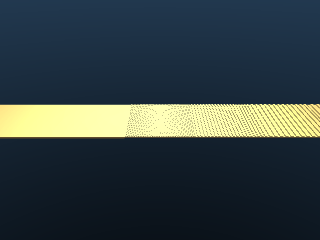

In [15]:
# Render
#camera = rendering.large_overview_camera()
camera = mujoco.MjvCamera()
mujoco.mjv_defaultCamera(camera)
camera.lookat = [0, 0, 0]
camera.distance = 18
camera.elevation = -30
# image = rendering.render_model(env_model, camera=camera, initial_keyframe="home")
mj_data = mujoco.MjData(env_model)
mj_data.qpos = init_qpos
with mujoco.Renderer(env_model) as renderer:
    mujoco.mj_forward(env_model, mj_data)
    renderer.update_scene(mj_data, camera=camera)
    image = renderer.render()
rendering.show_image(image)

In [6]:
mj_data.qpos

array([-32.  ,   0.  ,   0.32,   1.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.9 ,  -1.8 ,   0.  ,
         0.9 ,  -1.8 ,   0.  ,   0.9 ,  -1.8 ,   0.  ,   0.9 ,  -1.8 ])

In [7]:
from quadruped_mjx_rl.environments import get_env_factory
from quadruped_mjx_rl.robotic_vision import get_renderer
import functools
from quadruped_mjx_rl.environments.wrappers import wrap_for_training
import jax

make_renderer = functools.partial(get_renderer, vision_config=vision_config)
env_factory = get_env_factory(
    robot_config=robot_config,
    environment_config=environment_config,
    env_model=env_model,
    vision_config=vision_config,
    init_qpos=init_qpos,
    renderer_maker=make_renderer,
)
env = env_factory()

# env = wrap_for_training(
#     env=env,
#     vision=True,
#     num_vision_envs=training_config.num_envs,
# )
# jit_reset = jax.jit(env.reset)
# jit_step = jax.jit(env.step)

/usr/local/lib/python3.11/dist-packages/brax/io/mjcf.py:480: UserWarning: Brax System, piplines and environments are not actively being maintained. Please see MJX for a well maintained JAX-based physics engine: https://github.com/google-deepmind/mujoco/tree/main/mjx. For a host of environments that use MJX, see: https://github.com/google-deepmind/mujoco_playground.
  warnings.warn(


In [8]:
env = wrap_for_training(
    env=env,
    vision=True,
    num_vision_envs=training_config.num_envs,
)
jit_reset = jax.jit(env.reset)
jit_step = jax.jit(env.step)

In [9]:
state = jit_reset(jax.random.split(jax.random.PRNGKey(0), training_config.num_envs))

In [10]:
import jax.numpy as jnp
state = jit_step(state, jnp.zeros((training_config.num_envs, env.action_size)))

In [11]:
frontal_view = state.obs["pixels/view_frontal_ego"]
print(frontal_view.shape)
terrain_view = state.obs["pixels/view_terrain"]
print(terrain_view.shape)

(64, 64, 64, 3)
(64, 64, 64, 1)


In [12]:
import mediapy as media

def tile(img, d):
    assert img.shape[0] == d*d
    img = img.reshape((d,d)+img.shape[1:])
    return np.concat(np.concat(img, axis=1), axis=1)  # replace with 2 for multi-camera tensors!

# image = tile(rgb_tensor[:16], 4)
# image.shape
frontal_view_image = tile(frontal_view[:16], 4)
print(frontal_view_image.shape)
terrain_view_image = tile(terrain_view[:16], 4)
print(terrain_view_image.shape)

(256, 256, 3)
(256, 256, 1)


""

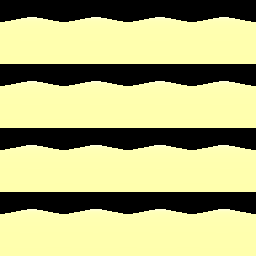

In [13]:
media.show_image(frontal_view_image, width=512)

""

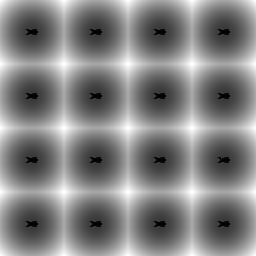

In [14]:
media.show_image(terrain_view_image, width=512)

In [14]:
# @title train
from quadruped_mjx_rl.training import training

train_fn = training.get_training_fn(
    model_config=model_config, training_config=training_config, vision=True
)
progress_fn, eval_times = training.make_progress_fn(num_timesteps=training_config.num_timesteps)

print("Starting training with vision...")
make_inference_fn, params, metrics = train_fn(
    environment=env,
    # eval_env=env,
    seed=0,
    # randomization_fn=domain_randomize,
    progress_fn=progress_fn,
    # wrap_env=False,
)
print(f"time to jit: {eval_times[1] - eval_times[0]}")
print(f"time to train: {eval_times[-1] - eval_times[1]}")

# Save params
training.save_params(results_path / "trial_run", params)


Starting training with vision...


UnexpectedTracerError: Encountered an unexpected tracer. A function transformed by JAX had a side effect, allowing for a reference to an intermediate value with type float32[261,4] wrapped in a BatchTracer to escape the scope of the transformation.
JAX transformations require that functions explicitly return their outputs, and disallow saving intermediate values to global state.
To catch the leak earlier, try setting the environment variable JAX_CHECK_TRACER_LEAKS or using the `jax.checking_leaks` context manager.
See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.UnexpectedTracerError